# Constraint-based algorithm: PC

In [1]:
import pandas as pd
df = pd.read_stata("data/close_college.dta")
display(df.head())

,nearc4,educ,black,smsa,south,married,exper,lwage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674


In [2]:
import os
os.environ['R_HOME'] = "C:/PROGRA~1/R/R-43~1.1" # PATH FEMKE

%load_ext rpy2.ipython

c:\Users\femke\anaconda3\envs\causal_data_science_env\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
# import necessary packages
from itertools import combinations

import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows
cdt.SETTINGS.rpath = 'C:/PROGRA~1/R/R-43~1.1/bin/Rscript' # for FEMKE PATH



#from dowhy import CausalModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.random import normal
import pandas as pd
import pingouin as pg

np.random.seed(0)

c:\Users\femke\anaconda3\envs\causal_data_science_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


### Functions

In [4]:
def get_positions(input_df):
    x =  [0, 1, 1, 0, -1, -1, 0.5, -0.5]
    y =  [1, 0.5, -0.5, -1, -0.5, 0.5, 0, 0]
    x = [i*4 for i in x]
    y = [i*4 for i in y]

    pos = dict()
    for i in range(len(input_df.columns)):
        node = list(input_df.columns.values)[i]
        pos[node] = (x[i], y[i])

    return pos

pos = get_positions(df)
print(pos)

{'nearc4': (0, 4), 'educ': (4, 2.0), 'black': (4, -2.0), 'smsa': (0, -4), 'south': (-4, -2.0), 'married': (-4, 2.0), 'exper': (2.0, 0), 'lwage': (-2.0, 0)}


In [5]:
def compare_edges(G1, G2):
    items_not_in_list2 = [item for item in G1.edges() if item not in G2.edges()]
    items_not_in_list1 = [item for item in G2.edges() if item not in G1.edges()]

    print("Items in -G1- not present in -G2- :")
    print(items_not_in_list2)
    print("\nItems in -G2- not present in -G1- :")
    print(items_not_in_list1)

### Guassian

Without prior knowledge

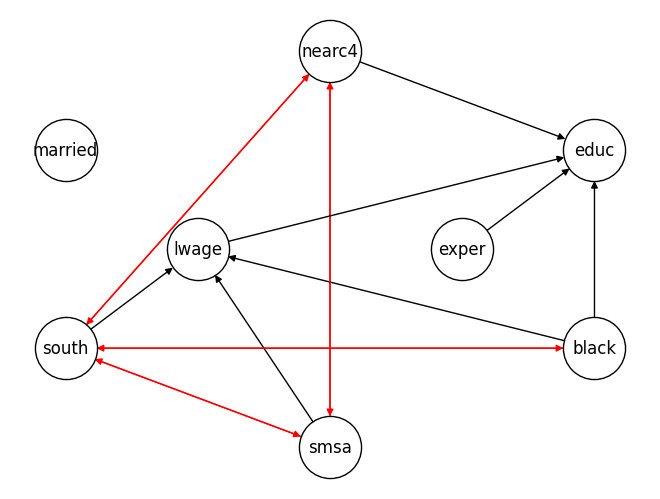

In [6]:
alpha = 0.05
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph_gaus = pc.create_graph_from_data(df)


colors = ['red'  if (y,x) in pc_graph_gaus.edges() else 'black' for (x,y) in pc_graph_gaus.edges()]
nx.draw(pc_graph_gaus, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

With prior knowledge:
- edge between lwage and exper
- edge between lwage and educ

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


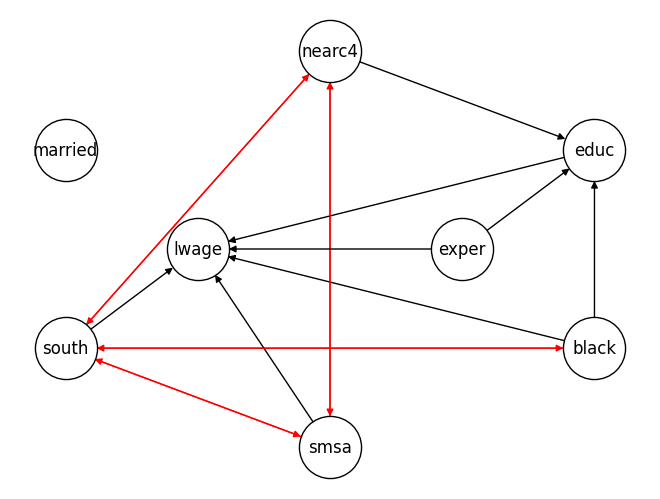

In [7]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)


### Define background knowledge ###
prior_graph = nx.DiGraph() # Create a graph to hold our background knowledge
prior_graph.add_nodes_from(df.columns) # Add nodes
prior_graph.add_edges_from([('exper', 'lwage'), ('lwage', 'exper')]) 
prior_graph.add_edges_from([('lwage', 'educ'), ('educ', 'lwage')]) 

fixed_edges = pd.DataFrame(nx.adjacency_matrix(prior_graph).todense()) # Symmetric adjacency matrix representing edges that exist
fixed_gaps = pd.DataFrame(np.zeros((8,8), dtype=int)) # Symmetric adjacency matrix representing edges that canNOT exist


### Run PC ###
pc.arguments['{CITEST}'] = pc.dir_CI_test[pc.CI_test]
pc.arguments['{METHOD_INDEP}'] = pc.dir_method_indep[pc.CI_test]
pc.arguments['{DIRECTED}'] = 'TRUE'
pc.arguments['{ALPHA}'] = str(pc.alpha)
pc.arguments['{NJOBS}'] = str(pc.njobs)
result = pc._run_pc(df, fixedEdges=fixed_edges, fixedGaps=fixed_gaps)
pc_graph_gaus_pk = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})

### Visalise ###
colors = ['red'  if (y,x) in pc_graph_gaus_pk.edges() else 'black' for (x,y) in pc_graph_gaus_pk.edges()]
nx.draw(pc_graph_gaus_pk, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

#### All possible DAGs

In [55]:
import os
def check_dags(G):
    if not nx.is_directed_acyclic_graph(G):
        return None
    
    folder = 'graph_files/PC_CPDAG_graphs'
    all_dags = os.listdir(folder)

    if len(all_dags)>0:
        for dag in all_dags:
            open_dag = nx.read_gml(f"{folder}/{dag}")

            if G.edges() == open_dag.edges():
                print(f"Warning: DAG matches with {dag}")
                return None
            
        current_number = int(all_dags[-1][3:4])
        file_name = f"{all_dags[-1][:-5]}{current_number+1}.gml"

    else:
        file_name = 'dag1.gml'
    nx.write_gml(G, f"{folder}/{file_name}")
    return None

    



In [58]:
from itertools import product

def get_all_dags(cpdag, folder):
    edge1 = [("south", 'smsa'), ('smsa', 'south')]
    edge2 = [("south", 'black'),('black', 'south')]
    edge3 = [('south', 'nearc4'), ('nearc4', 'south')]
    edge4 = [('nearc4', 'smsa'), ('smsa', 'nearc4')]

    all_combinations = list(product(edge1, edge2, edge3, edge4))
    for combination in all_combinations:
        edges = list(combination)
        possible_dag = cpdag.copy()
        possible_dag.remove_edges_from(edges)
        check_dags(possible_dag)
        

get_all_dags(pc_graph_gaus_pk, 'graph_files/PC_CPDAG_graphs')


    

16


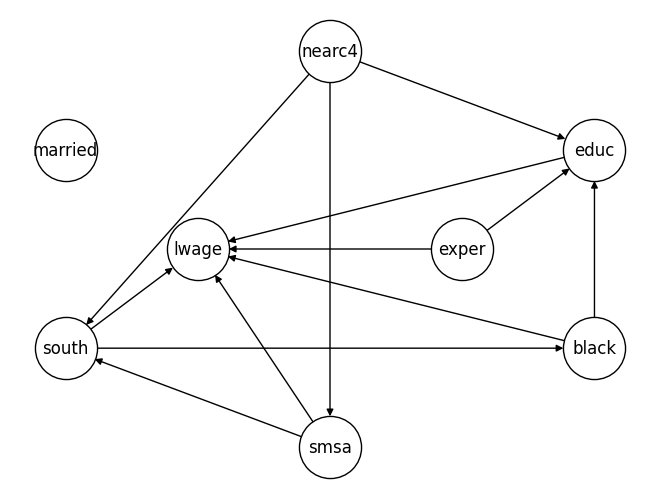

In [51]:
### DAG 2
dag2 = pc_graph_gaus_pk.copy()
dag2.remove_edge('south', 'smsa')
dag2.remove_edge('black', 'south')
dag2.remove_edge("south", 'nearc4')
dag2.remove_edge("smsa", 'nearc4')

colors = ['red'  if (y,x) in dag2.edges() else 'black' for (x,y) in dag2.edges()]
nx.draw(dag2, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

check_dags(dag2, 'dag2')





1


UnboundLocalError: local variable 'file_name' referenced before assignment

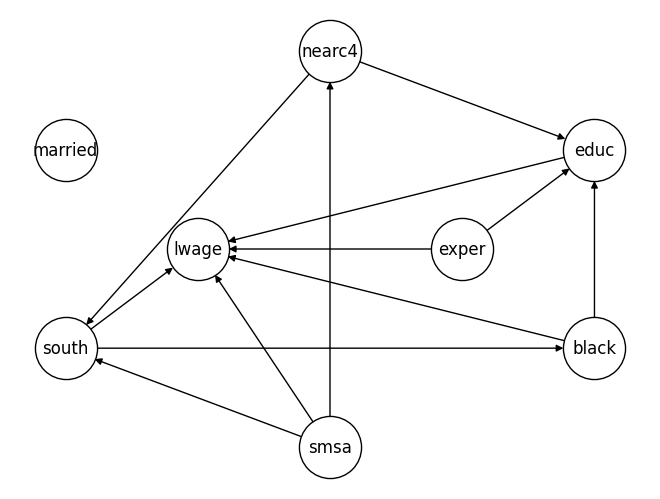

In [52]:
### DAG 1
dag1 = pc_graph_gaus_pk.copy()
dag1.remove_edge('south', 'smsa')
dag1.remove_edge('black', 'south')
dag1.remove_edge("south", 'nearc4')
dag1.remove_edge("nearc4", 'smsa')

colors = ['red'  if (y,x) in dag1.edges() else 'black' for (x,y) in dag1.edges()]
nx.draw(dag1, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)
check_dags(dag1, 'graph_files/PC_CPDAG_graphs')




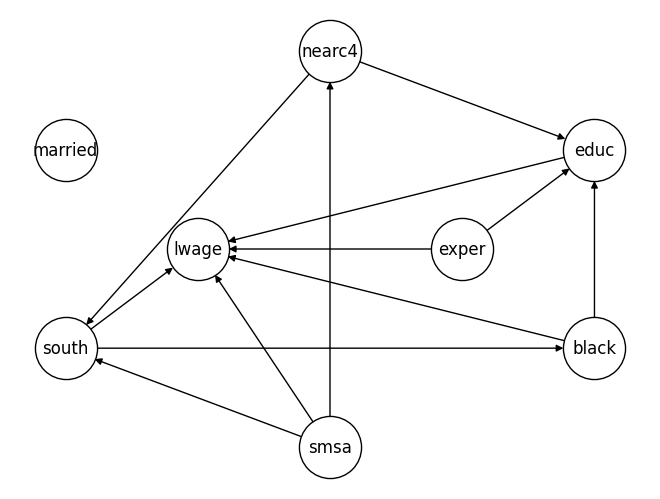

In [44]:
### DAG 1
dag1 = pc_graph_gaus_pk.copy()
dag1.remove_edge('south', 'smsa')
dag1.remove_edge('black', 'south')
dag1.remove_edge("south", 'nearc4')
dag1.remove_edge("nearc4", 'smsa')

colors = ['red'  if (y,x) in dag1.edges() else 'black' for (x,y) in dag1.edges()]
nx.draw(dag1, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

if nx.is_directed_acyclic_graph(dag1):
    nx.write_gml(dag1, "graph_files/dag1.gml")
else:
    print("Warning: NOT A DAG")



In [21]:
nx.is_directed_acyclic_graph(dag1)

True

Check if without prior knowlegde has the same edges as with prior knowledge:

In [9]:
print(pc_graph_gaus.edges() == pc_graph_gaus_pk.edges())
compare_edges(pc_graph_gaus,pc_graph_gaus_pk)

False
Items in -G1- not present in -G2- :
[('lwage', 'educ')]

Items in -G2- not present in -G1- :
[('educ', 'lwage'), ('exper', 'lwage')]


### Prove causality

In [10]:
from sklearn.linear_model import LinearRegression
X = df[['educ', 'black', 'exper', 'nearc4']]
Y = df[['lwage']]
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
linear_regressor.coef_[:,1]

array([-0.22810174])

In [17]:
from sklearn.linear_model import LinearRegression
X = df[['educ', 'black', 'exper', 'smsa', 'south']]
Y = df[['lwage']]
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
linear_regressor.coef_[:,1]

array([-0.18822254])

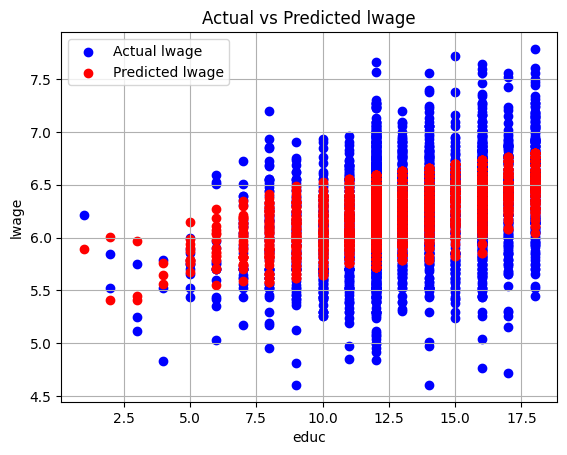

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming df is your DataFrame containing the lwage and educ columns
# And X, Y, linear_regressor are defined as you specified

# Fit the linear regression model
# linear_regressor.fit(X, Y)

# Predict the lwage values
lwage_pred = linear_regressor.predict(X)

# Plot lwage against educ
plt.scatter(df['educ'], Y, color='blue', label='Actual lwage')
plt.scatter(df['educ'], lwage_pred, color='red', label='Predicted lwage')
plt.xlabel('educ')
plt.ylabel('lwage')
plt.title('Actual vs Predicted lwage')
plt.legend()
plt.grid(True)
plt.show()


### Backdoor criterion

In [ ]:
import dowhy
from dowhy import CausalModel
from IPython.display import Image, display

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str


def dowhy_backdoor(file):

    # creating arbitrary data
    df = pd.read_stata("data/close_college.dta")

    gml_graph = gml_to_string(file)
    # With GML string
    model=CausalModel(
        data = df,
        treatment='educ',
        outcome='lwage',
        graph=gml_graph
    )

    identified_estimand = model.identify_effect()
    print(identified_estimand)

dowhy_backdoor("graph_files/dag1.gml")


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                
───────(E[lwage|exper,nearc4,black])
d[educ]                             
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,exper,nearc4,black,U) = P(lwage|educ,exper,nearc4,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

